In [31]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import json
import torch
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import (
    accuracy_score, 
    adjusted_rand_score,
    mutual_info_score,
    classification_report, 
    confusion_matrix,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
    LearningCurveDisplay,
    ShuffleSplit
)

from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform

import xgboost as xgb
from xgboost import XGBClassifier
import shap

In [8]:
data_dir = Path("M:/neuro2voc/task-5/tf-idf-data-labels")
dfs = []
for i in range(3):
    file_path = data_dir / f"tf-idf-{i}.csv"
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,label
0,0.000000,0.110599,0.000000,0.038573,0.056340,0.000000,0.131188,0.629779,0.169070,0.000000,...,0.059984,0.052617,0.076334,0.000000,0.051810,0.0,0.000000,0.000000,0.000000,2
1,0.000000,0.156129,0.000000,0.145205,0.000000,0.083727,0.000000,0.049391,0.079557,0.124977,...,0.000000,0.049519,0.000000,0.124369,0.000000,0.0,0.000000,0.000000,0.000000,2
2,0.000000,0.050524,0.000000,0.105725,0.000000,0.121924,0.039953,0.479493,0.347555,0.000000,...,0.054804,0.000000,0.069742,0.080492,0.000000,0.0,0.000000,0.000000,0.137138,2
3,0.000000,0.000000,0.000000,0.080573,0.058842,0.092918,0.045672,0.000000,0.044145,0.000000,...,0.187946,0.054955,0.000000,0.138022,0.000000,0.0,0.000000,0.000000,0.000000,2
4,0.084123,0.068863,0.045069,0.096068,0.023386,0.055394,0.072607,0.000000,0.052635,0.073498,...,0.074697,0.000000,0.031686,0.036570,0.021506,0.0,0.000000,0.046227,0.031153,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.000000,0.000000,0.000000,0.060652,0.185863,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.077368,0.080413,0.0,0.107470,0.000000,0.110151,6
3455,0.019081,0.031976,0.048448,0.228617,0.015230,0.024321,0.044981,0.000000,0.060110,0.000000,...,0.017560,0.014448,0.015071,0.000000,0.118604,0.0,0.052837,0.000000,0.000000,7
3456,0.000000,0.038720,0.039111,0.192578,0.018442,0.103076,0.068084,0.142277,0.116459,0.254312,...,0.085053,0.034991,0.036499,0.061413,0.079788,0.0,0.042654,0.000000,0.043718,3
3457,0.000000,0.038029,0.000000,0.165499,0.036225,0.086774,0.026748,0.174673,0.285952,0.117540,...,0.041767,0.034367,0.071695,0.030159,0.094036,0.0,0.000000,0.068155,0.000000,4


In [9]:
# drop 8
combined_df = combined_df[combined_df['label'] != 8]

# start from 0
combined_df['label'] = combined_df['label'] - 2

# data
X = combined_df.iloc[:, :75] 
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# unique classes
print("Unique classes in y:", np.unique(y))

Unique classes in y: [0 1 2 3 4 5]


In [10]:
# K-means
kmeans_train = KMeans(n_clusters=6, random_state=42)
train_clusters = kmeans_train.fit_predict(X_train)

# cluster centers and sizes
train_cluster_centers = kmeans_train.cluster_centers_
train_cluster_sizes = np.bincount(train_clusters)

# print
print("Cluster Sizes:")
for i, size in enumerate(train_cluster_sizes):
    print(f"Cluster {i}: {size} samples")
    
print("\nCluster Centers (Top 5 most important words per cluster):")
for i, center in enumerate(train_cluster_centers):
    # Get indices of top 5 words in this cluster center
    top_word_indices = np.argsort(center)[-5:][::-1]
    print(f"\nCluster {i} top words (indices):", top_word_indices)
    print(f"Corresponding weights:", center[top_word_indices])

Cluster Sizes:
Cluster 0: 463 samples
Cluster 1: 245 samples
Cluster 2: 300 samples
Cluster 3: 480 samples
Cluster 4: 702 samples
Cluster 5: 573 samples

Cluster Centers (Top 5 most important words per cluster):

Cluster 0 top words (indices): [14 11 13  3 28]
Corresponding weights: [0.53172089 0.47755859 0.21865844 0.20087981 0.14044386]

Cluster 1 top words (indices): [14 11  7 13  3]
Corresponding weights: [0.4826688  0.4235759  0.34333633 0.18880877 0.16481994]

Cluster 2 top words (indices): [14 11  9 10 13]
Corresponding weights: [0.4830812  0.39035512 0.3595404  0.26862493 0.18490249]

Cluster 3 top words (indices): [14 11 13  3  7]
Corresponding weights: [0.52315675 0.50844581 0.20556548 0.19825955 0.16990726]

Cluster 4 top words (indices): [14 11 13  3 33]
Corresponding weights: [0.55694765 0.51538247 0.20891082 0.19751951 0.08189132]

Cluster 5 top words (indices): [14 11 13 10  3]
Corresponding weights: [0.53269549 0.46481318 0.20947406 0.19264612 0.19110815]


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [12]:
# intra-cluster distance
intra_distances = []
for i in range(6):
    cluster_points = X_train[train_clusters == i]
    if len(cluster_points) > 1:
        distances = pdist(cluster_points)
        intra_distances.append(np.mean(distances))
    else:
        intra_distances.append(0)

# inter-cluster distances
inter_distances = np.zeros((6, 6))
for i in range(6):
    for j in range(i+1, 6):
        dist = np.linalg.norm(train_cluster_centers[i] - train_cluster_centers[j])
        inter_distances[i,j] = dist
        inter_distances[j,i] = dist

distance_df = pd.DataFrame(
    inter_distances,
    index=[f'Cluster {i}' for i in range(6)],
    columns=[f'Cluster {i}' for i in range(6)]
)
distance_df['Intra-cluster'] = intra_distances

print("\nDistance Matrix:")
print(distance_df)


Distance Matrix:
           Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
Cluster 0   0.000000   0.373423   0.409782   0.210530   0.183263   0.229644   
Cluster 1   0.373423   0.000000   0.410643   0.238331   0.388900   0.344797   
Cluster 2   0.409782   0.410643   0.000000   0.428832   0.432611   0.216051   
Cluster 3   0.210530   0.238331   0.428832   0.000000   0.196358   0.259049   
Cluster 4   0.183263   0.388900   0.432611   0.196358   0.000000   0.235647   
Cluster 5   0.229644   0.344797   0.216051   0.259049   0.235647   0.000000   

           Intra-cluster  
Cluster 0       0.598248  
Cluster 1       0.634447  
Cluster 2       0.611023  
Cluster 3       0.555123  
Cluster 4       0.607308  
Cluster 5       0.577556  


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


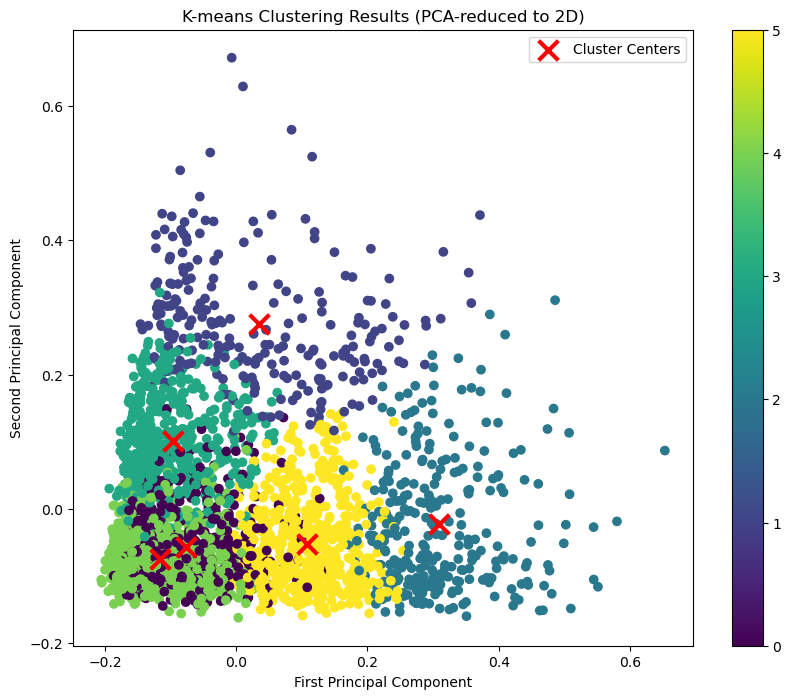

In [14]:
# visualize with pca
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_clusters, cmap='viridis')
plt.colorbar(scatter)
centers_2d = pca.transform(train_cluster_centers)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('K-means Clustering Results (PCA-reduced to 2D)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

# SVM

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc = SVC(random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
test_score = grid_search.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_score:.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.7999
Test set accuracy: 0.8017


# RF

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
test_score = grid_search.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_score:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.8498
Test set accuracy: 0.8466


In [46]:
# First, create feature_importances DataFrame
feature_importances = pd.DataFrame(
    grid_search.best_estimator_.feature_importances_,
    index=[f'Feature {i}' for i in range(X_train.shape[1])],
    columns=['Importance']
).sort_values('Importance', ascending=False)

# Add depth information
feature_importances['Depth'] = feature_importances.index.map(lambda x: idx2depth[str(int(x.split()[1]))])

In [47]:
feature_importances

,Importance,Depth
Feature 69,0.043979,2180
Feature 67,0.032131,2100
Feature 17,0.029581,2420
Feature 19,0.024246,2440
Feature 11,0.022218,2300
...,...,...
Feature 74,0.006705,3380
Feature 21,0.005972,2480
Feature 71,0.005721,2360
Feature 20,0.005363,2460


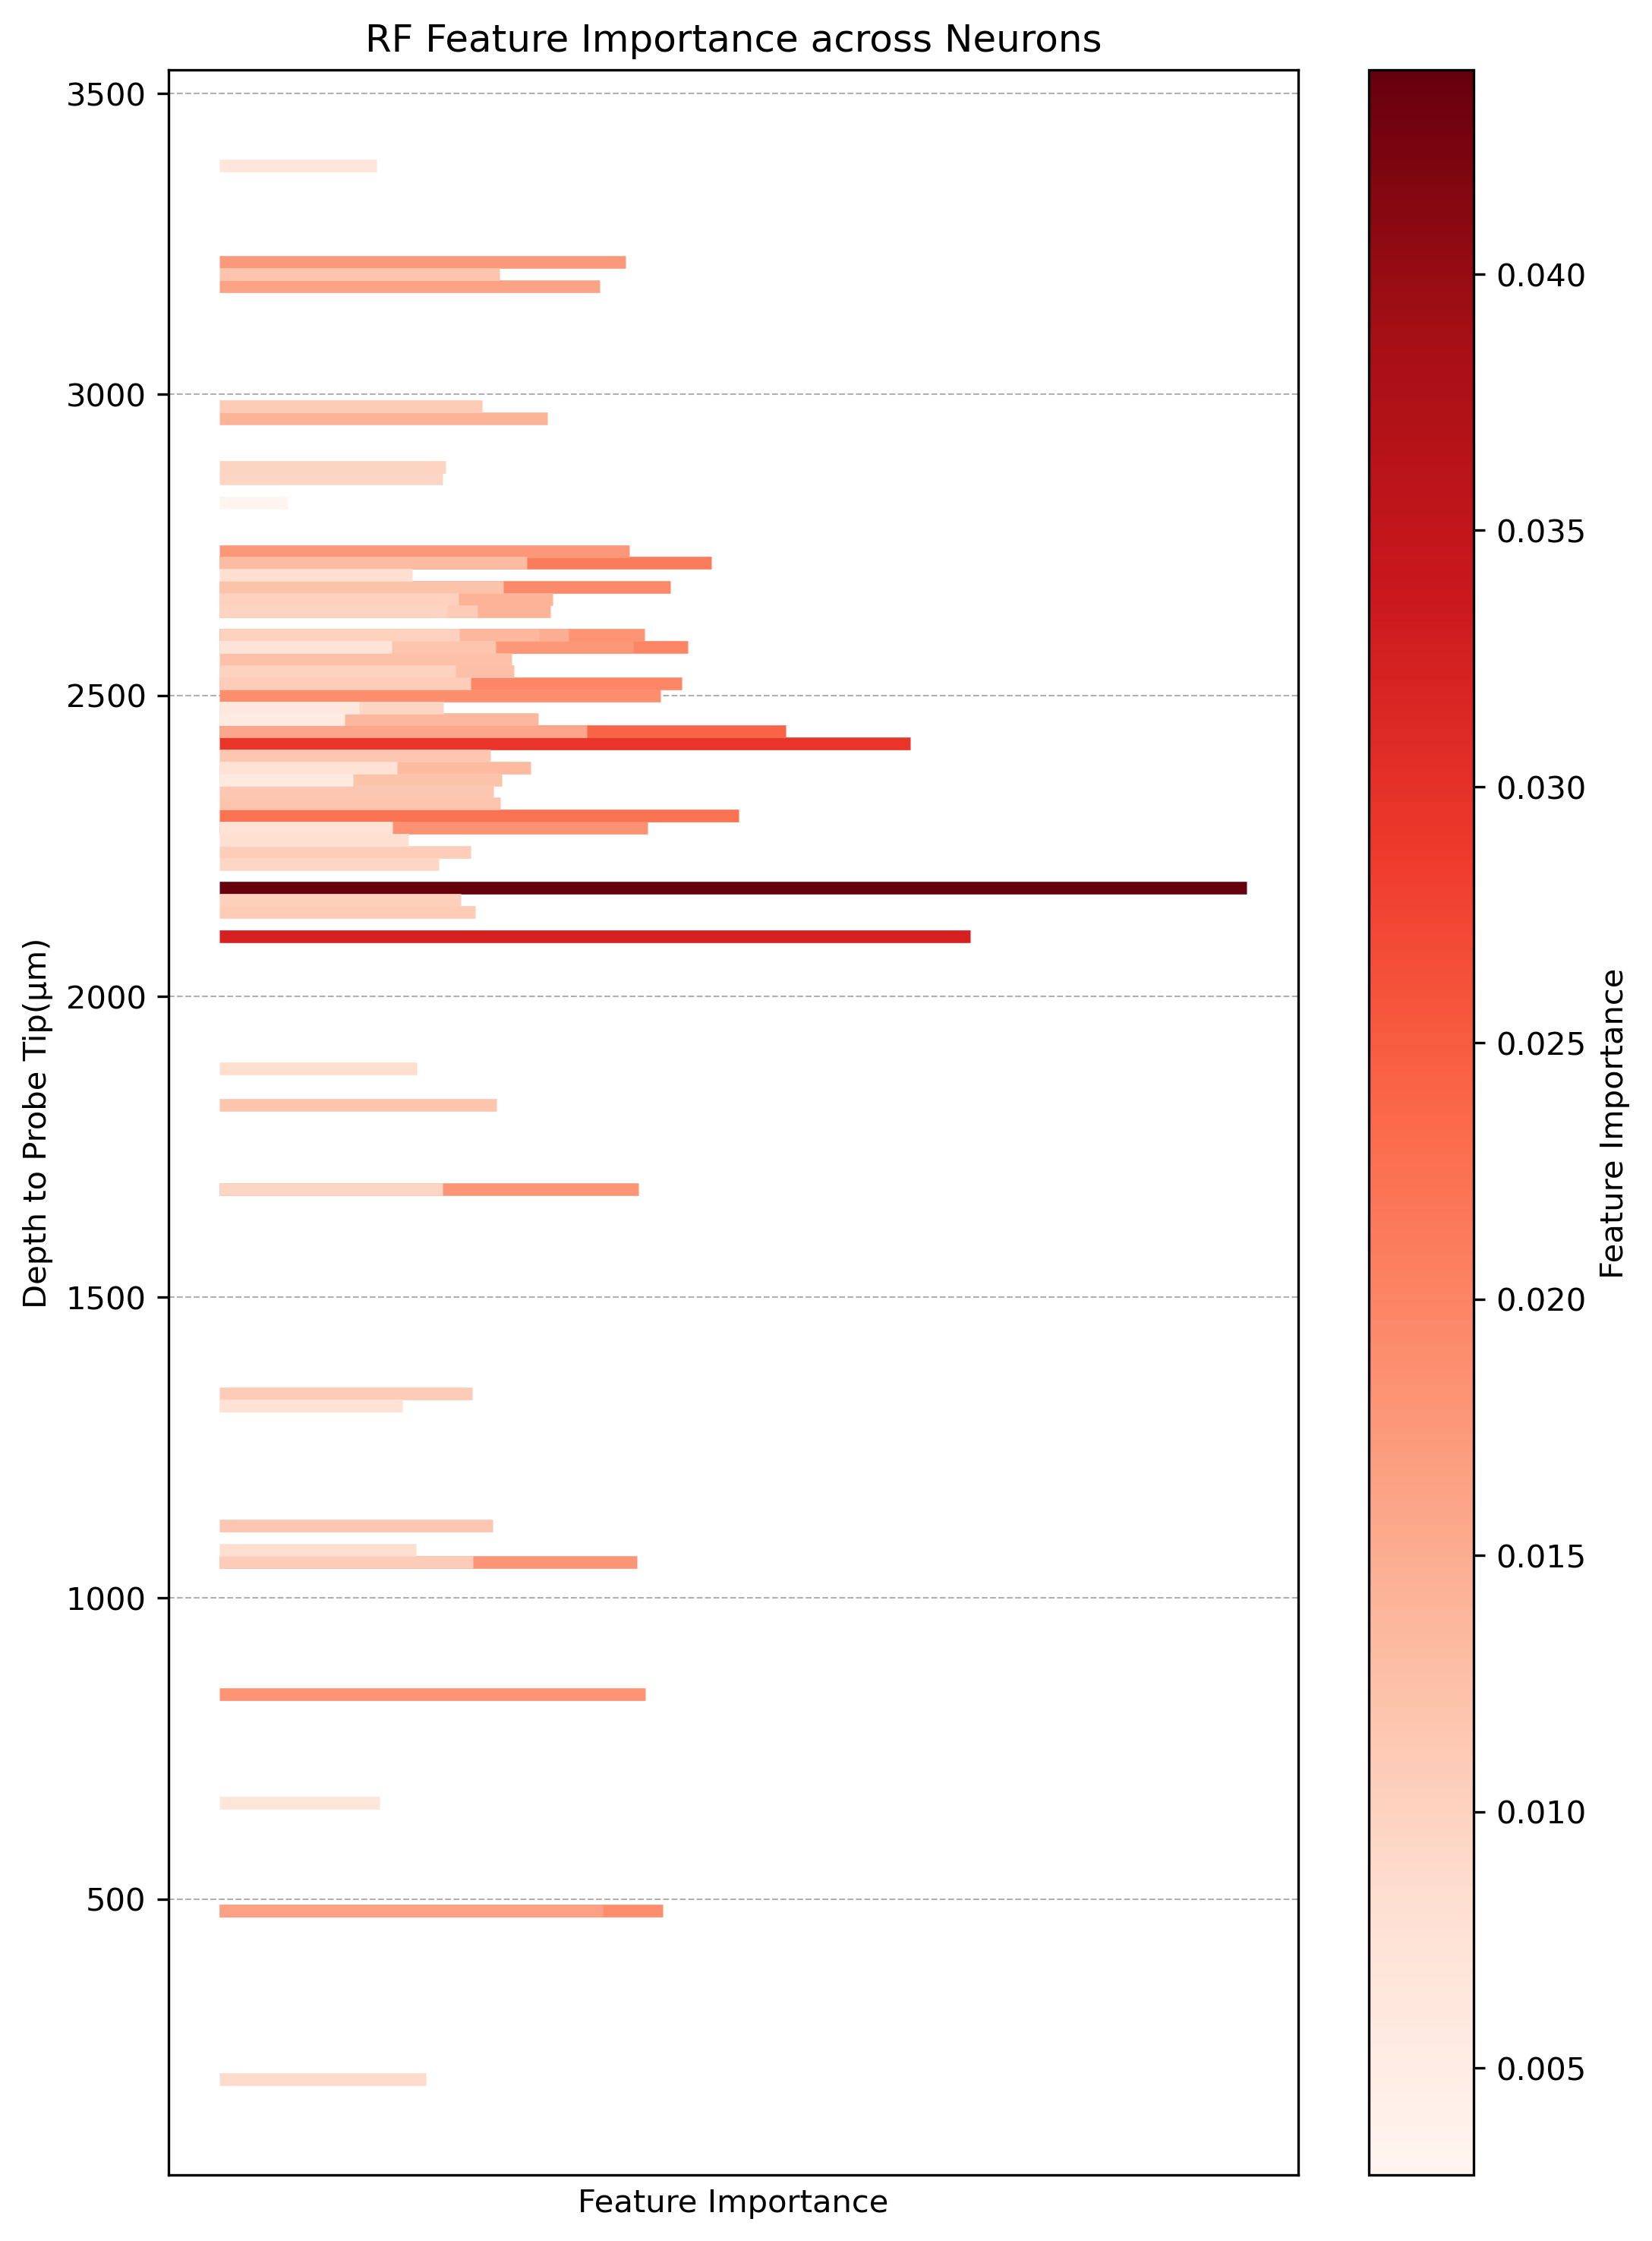

Number of features: 75

Top 5 important features:
            Importance  Depth
Feature 69    0.043979   2180
Feature 67    0.032131   2100
Feature 17    0.029581   2420
Feature 19    0.024246   2440
Feature 11    0.022218   2300


In [50]:
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), 
                        vmax=feature_importances['Importance'].max())

# Create plot
colormap = plt.cm.Reds
fig, ax = plt.subplots(figsize=(8, 12), dpi=300)

# Plot feature importances as horizontal lines
for idx, row in feature_importances.iterrows():
    neuron_num = idx.split()[1]
    ax.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Importance'],
        color=colormap(norm(row['Importance'])),
        linewidth=4,
        label=f'Neuron {neuron_num}'
    )

# Create a color bar
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), 
            ax=ax, label='Feature Importance')

# Label the axes
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Depth to Probe Tip(μm)')
ax.set_title('RF Feature Importance across Neurons')

# Remove x-axis labels and ticks
ax.set_xticks([])

# Show the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

plt.savefig('result_RF_TF-IDF.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Debug prints
print("Number of features:", len(feature_importances))
print("\nTop 5 important features:")
print(feature_importances.head())

# XGBoost

In [24]:
feature_importances

NameError: name 'feature_importances' is not defined

In [19]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bynode': [0.8]
}

xgb_rf = xgb.XGBRFClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=42, reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bynode': [0.8], 'learning_rate': [0.1, 0.3],
                         'max_depth': [3, 6], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [20]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
best_xgb_rf = grid_search.best_estimator_
test_score = best_xgb_rf.score(X_test, y_test)
print("Test set accuracy:", test_score)
y_pred = best_xgb_rf.predict(X_test)

Best parameters: {'colsample_bynode': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.7738062478706398
Test set accuracy: 0.7771345875542692


In [ ]:
print("Classification Report")
print(classification_report(y_test, y_pred))

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# feature importance
feature_importance = best_xgb_rf.feature_importances_
top_features = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

print("Top 10 important features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. Feature {feature}: {feature_importance[feature]}")